In [1]:
import wordgraph as wg
import os

from ggplot import *
import pandas as pd
from scipy import stats
import numpy as np

from nltk.stem.snowball import SnowballStemmer
stemmer= SnowballStemmer("english")

In [2]:
G = wg.WordGraph()

In [3]:
def range_degree_merge_wb(graph_dir, wordbank_csv):
    wb_data = pd.read_csv(wordbank_csv)
    words = wb_data['definition'].str.strip().str.replace("+", "-").str.replace(" ", "-").str.lower()
    stemmed_words = [stemmer.stem(x) for x in words]
    wb_data['definition'] = stemmed_words
    deg_dists = []
    
    for root, dirs, files in os.walk(graph_dir):
        for file in files:
            if not file.startswith("."):
                file = os.path.join(root, file)
                G.load_pickle(file)
                deg_dist = G.degree_distribution()
                deg_dist = pd.merge(deg_dist, wb_data, left_on='word', right_on='definition')
                deg_dists.append((G.epsilon, deg_dist))              
    return deg_dists

In [4]:
def spearman_dist_range(wordset, degree_dists, month):
    df = pd.DataFrame(columns=['wordset', 'epsilon', 'rho', 'p', 'cdi_month'])
    for pair in degree_dists:
        rho, p = stats.spearmanr(pair[1]['degree'], pair[1][month])
        entry = pd.DataFrame([[wordset, pair[0], rho, p, month]], columns=['wordset', 'epsilon', 'rho', 'p', 'cdi_month'])
        df = df.append(entry, ignore_index=True)
    return df

## Merge WordBank comprehension scores with SEEDLings degree distributions

In [8]:
degree_dists_6mo = range_degree_merge_wb(graph_dir='/Volumes/Lexar/semspace_output/childes/6',
                                         wordbank_csv='data/wordbank_english.csv')

degree_dists_1617mo = range_degree_merge_wb(graph_dir='/Volumes/Lexar/semspace_output/childes/1617',
                                            wordbank_csv='data/wordbank_english.csv')

degree_dists_all = range_degree_merge_wb(graph_dir='/Volumes/Lexar/semspace_output/childes/all',
                                         wordbank_csv='data/wordbank_english.csv')

wb_degree_dist = range_degree_merge_wb(graph_dir='/Volumes/Lexar/semspace_output/childes/wordbank',
                                       wordbank_csv='data/wordbank_english.csv')

# Calculate Spearman Correlation

In [10]:
%%capture
seed_6mo_16 = spearman_dist_range('seedlings_6mo', degree_dists_6mo, '16')
seed_1617mo_16 = spearman_dist_range('seedlings_1617mo', degree_dists_1617mo, '16')
seed_all_16 = spearman_dist_range('seedlings_all', degree_dists_all, '16')

seed_6mo_23 = spearman_dist_range('seedlings_6mo', degree_dists_6mo, '23')
seed_1617mo_23 = spearman_dist_range('seedlings_1617mo', degree_dists_1617mo, '23')
seed_all_23 = spearman_dist_range('seedlings_all', degree_dists_all, '23')

seed_6mo_30 = spearman_dist_range('seedlings_6mo', degree_dists_6mo, '30')
seed_1617mo_30 = spearman_dist_range('seedlings_1617mo', degree_dists_1617mo, '30')
seed_all_30 = spearman_dist_range('seedlings_all', degree_dists_all, '30')

# seed_6mo_23_30 = spearman_dist_range('seedlings_6mo', degree_dists_6mo, '23_to_30')
# seed_1617mo_23_30 = spearman_dist_range('seedlings_1617mo', degree_dists_1617mo, '23_to_30')
# seed_all_23_30 = spearman_dist_range('seedlings_all', degree_dists_all, '23_to_30')

wordbank_16 = spearman_dist_range('wordbank', wb_degree_dist, "16")
wordbank_23 = spearman_dist_range('wordbank', wb_degree_dist, "23")
wordbank_30 = spearman_dist_range('wordbank', wb_degree_dist, "30")
# wordbank_23_30 = spearman_dist_range('wordbank', wb_degree_dist, "23_to_30")

data = pd.concat([seed_6mo_16, seed_1617mo_16, seed_all_16,
                 seed_6mo_23, seed_1617mo_23, seed_all_23,
                 seed_6mo_30, seed_1617mo_30, seed_all_30,
                # seed_6mo_23_30, seed_1617mo_23_30, seed_all_23_30,
                 wordbank_16, wordbank_23, wordbank_30])

data.to_csv('output/wordlearning_childes.csv', index=False)

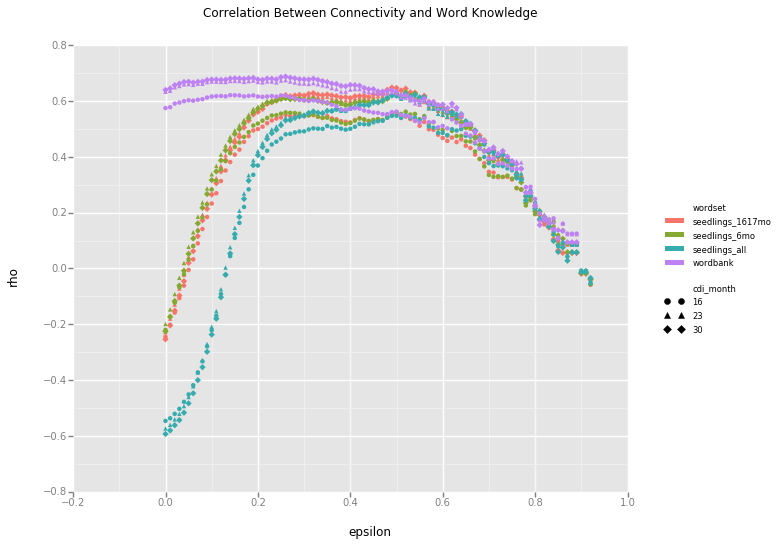

<ggplot: (-9223372036559616561)>

In [11]:
p = ggplot(data, aes(x='epsilon', y='rho', color='wordset', shape='cdi_month'))+\
    geom_point()+\
    ggtitle('Correlation Between Connectivity and Word Knowledge')
    
p